In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from astropy import units as u
from astropy import constants as const
from astroquery.simbad import Simbad
from astropy.io import ascii
from astropy.time import Time, TimeDelta
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.table import Table
from scipy.stats import binned_statistic, binned_statistic_2d
from scipy.optimize import curve_fit


In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
# lets play with the reported observation data from the MPC, as of 2025-July-17
# https://minorplanetcenter.net/db_search/show_object?utf8=✓&object_id=3I

# 0003I         C2025 05 22.37361119 03 19.706-18 41 58.89         20.50gUEN051I41

mpc = ascii.read('data/3I.txt', format='fixed_width_no_header',
                names=('oid', 'date', 'ra', 'dec', 'mag','filter'),
                col_starts=(0, 15, 32, 44, 65, 70),
                col_ends = (15,31, 43, 57, 69, 70),
                )
mpc

oid,date,ra,dec,mag,filter
str16,str17,str12,str13,float64,str1
0003I C2,2025 05 22.373611,19 03 19.706,-18 41 58.89,20.5,g
0003I C2,2025 05 22.396817,19 03 18.512,-18 41 58.79,20.08,r
0003I C2,2025 05 27.377060,18 58 54.067,-18 42 35.63,20.38,r
0003I C2,2025 06 04.361643,18 50 26.886,-18 43 58.30,19.88,r
0003I C2,2025 06 08.340926,18 45 32.966,-18 44 40.41,--,--
0003I C2,2025 06 08.399676,18 45 28.367,-18 44 41.01,19.77,g
0003I C2,2025 06 10.342037,18 42 54.177,-18 44 58.96,19.4,r
0003I C2,2025 06 14.252037,18 37 22.089,-18 45 26.50,19.67,g
0003I C2,2025 06 18.358808,18 31 01.091,-18 45 35.62,18.63,r


In [4]:
mpc['date'][28]

'2025 07 01.218880'

In [5]:
dates = np.zeros(len(mpc))
for k in range(len(mpc)):
    try:
        tmp = mpc['date'][k]
        t = Time({'year':int(tmp[0:4]), 'month':int(tmp[5:7]), 'day':int(float(tmp[8:]))} )
        dt = TimeDelta(float(tmp[10:]), format='jd')
        dates[k] = (t+dt).jd
    except:
        print('no')

['0' 'G' 'R' 'T' 'V' 'c' 'g' 'i' 'o' 'r' 'w' 'z']


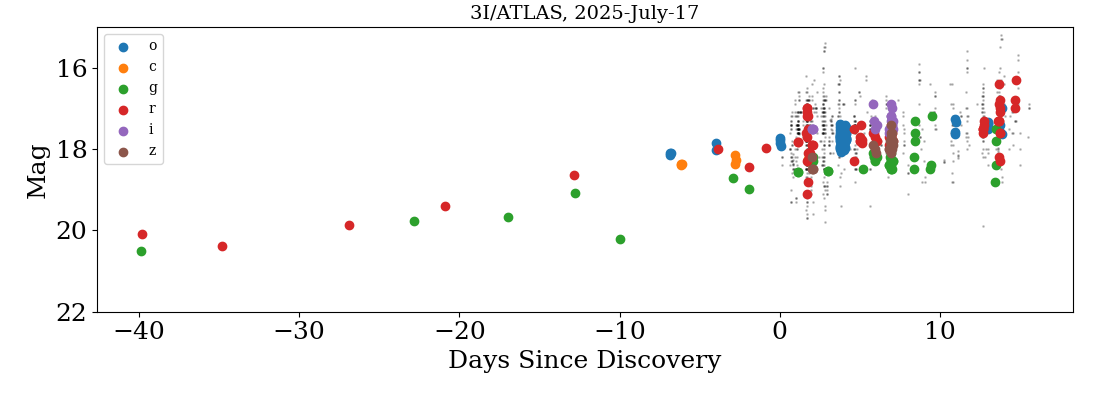

In [6]:
kf = np.unique(np.array(mpc['filter'].value))
print(kf)
kf = ['o', 'c', 'g', 'r', 'i', 'z']

plt.figure(figsize=(11,4))
plt.scatter(dates - dates[28], mpc['mag'], s=1, c='k', alpha=0.2)
for k in kf:
    # print(np.sum(
    plt.scatter(dates[mpc['filter'] == k] - dates[28],
                mpc['mag'][mpc['filter'] == k], label=k)
plt.ylim(22,15)
plt.xlabel('Days Since Discovery')
plt.ylabel('Mag')
plt.legend(fontsize=10)
plt.tight_layout()
plt.title('3I/ATLAS, 2025-July-17',fontsize=14)
plt.show()
plt.savefig('mpc_lc.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

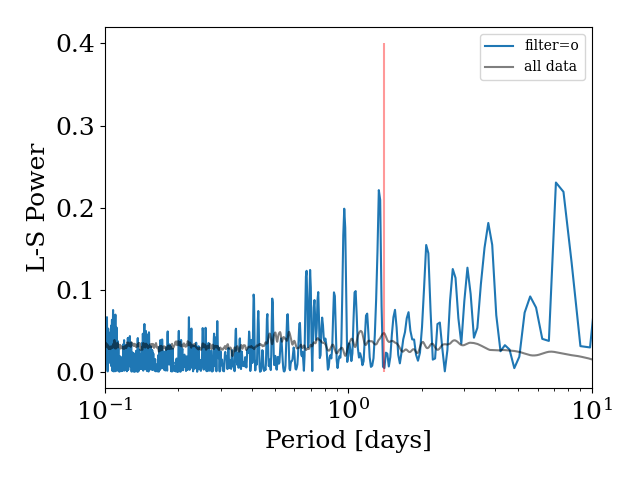

In [10]:
frequency, power = LombScargle(dates[mpc['filter']=='o'] - dates[28], 
                               np.array(mpc['mag'][mpc['filter']=='o'])).autopower()

plt.figure()
plt.plot(1./frequency, power, c='C0', label='filter=o')
frequency, power = LombScargle(dates - dates[28], np.array(mpc['mag'])).autopower()
plt.plot(1./frequency, power*5, c='k', alpha=0.5, label='all data')

# rotation period published July 18: https://arxiv.org/abs/2507.12922
plt.vlines(16.79/24., 0, 0.4, color='r', alpha=0.4)

plt.xscale('log')
plt.xlim(0.1,10)
plt.xlabel('Period [days]')
plt.ylabel('L-S Power')
plt.legend(fontsize=10)
plt.tight_layout()
# plt.savefig('lombscargle.png', dpi=150, bbox_inches='tight', pad_inches=0.25)